# Predicting Sepsis Event using Patient Baseline Characteristics: Feature selection methods comparison 
*Author 1:  Yiren Shao*, *Author 2: Zihan Wang*



## Introduction
The aim of the project is try to use patient baseline characteristics to predict sepsis event in the future. The dataset we used contains ICU patient information which included one binary outcome variable (sepsis event) and 40 potential predictors (e.g. demographic and laboratory measurement). Four variable selection methods were performed, including conventional selection method using LASSO, stepwise p value and AIC, plus machine learning method such as random forest. Two additional full model (logistic regression and random forest at defualt setting) were also constructed to compare the performance of variable selection. A best model used selected using ROC and highest AUC. In addtion, A parsimony plot was drawn to take consideration of both model accuracy and sparsity. When a model is both sparse and good in prediction accuracy, it is called parsimonious. Sparsity refers to the model using the least number of variables selected. Lastly, we tried if it is possible to find a potential variable set to predict sepsis event from baseline characteristics.


## Data cleaning

The aim of data preprossing is to get the baseline characteristics of each patient and if a patient has ever been diagnosed as sepsis. We first get rid of any columns that has missing value greater than 40%. Then get only complete cases for each patient. Final analytical dataset contains 6865 patients in total (983 sepsis: label 1, 5882 non-sepsis: label 0). We assume all the missingness are complete at random.  

#### The datasets are in Box, Link: https://duke.box.com/s/yaavd2ysects14zv76zmi5yjtcde0olt

In [1]:
# packages
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("data/sepsistrain.psv")

In [3]:
# group by 'SubjectID' and calculate the sum of 'sepsis label'
sepsis_counts = df.groupby('SubjectID')['SepsisLabel'].sum()

# create a new data frame with 'SubjectID' and 'ever_sepsis' columns
new_df = pd.DataFrame({'SubjectID': sepsis_counts.index, 'ever_sepsis': sepsis_counts})

# replace any non-zero values in 'ever_sepsis' with 1
new_df.loc[new_df['ever_sepsis'] > 0, 'ever_sepsis'] = 1

# reset the index of the new data frame
new_df = new_df.reset_index(drop=True)

# merge the new data frame with the original data frame on 'SubjectID'
df = pd.merge(df, new_df, on='SubjectID')


In [4]:
# group by 'SubjectID' and select the first observation of each patient
first_obs = df.groupby('SubjectID').first().reset_index()

In [5]:
# drop the 'SepsisLabel' column
temp = first_obs.drop('SepsisLabel', axis=1)

# drop the 'pH' column
temp = temp.drop('pH', axis=1)


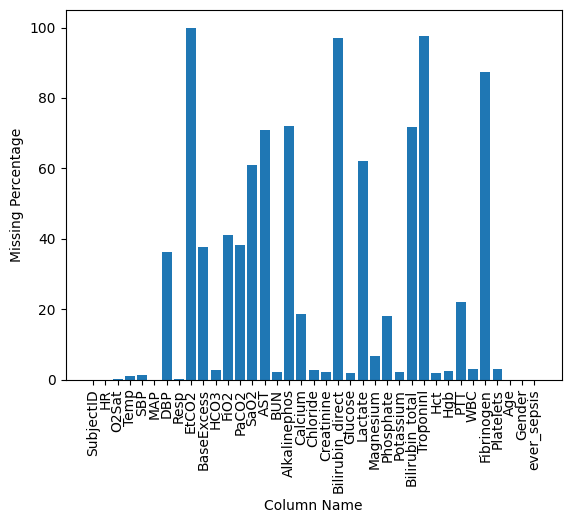

In [6]:
# calculate the missing percentage of each column
missing_percent = temp.isna().mean() * 100

# plot a bar plot of the missing percentage
plt.bar(missing_percent.index, missing_percent)
plt.xticks(rotation=90)
plt.xlabel('Column Name')
plt.ylabel('Missing Percentage')
plt.show()


In [7]:
# drop the columns with missing percentage greater than 40%
temp_reduced = temp.drop(missing_percent[missing_percent > 40].index, axis=1)


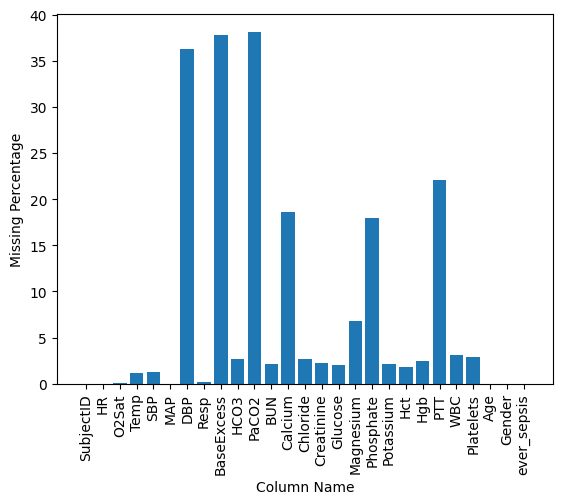

In [8]:
# calculate the missing percentage of each column
missing_percent_2 = temp_reduced.isna().mean() * 100

# plot a bar plot of the missing percentage
plt.bar(missing_percent_2.index, missing_percent_2)
plt.xticks(rotation=90)
plt.xlabel('Column Name')
plt.ylabel('Missing Percentage')
plt.show()

In [9]:
# get the complete cases
df_final = temp_reduced.dropna()

In [10]:
#df_final.to_csv('data/df_final.csv', index=False)

## Methods / Implementation

We first plot a correlation plot to exam the potential collinearity problem between predictors. The most correlated predictors are (MAP and DBP/SBP ~ 0.8 correlation) and (Hct and Hgb ~ 1.0 correlation) and (HCO3 and BaseExcess ~0.7 correlation) and (creatinine and bun ~ 0.7 correlation). Therefore, within these four combination, we will only need to keep one of each. Our choice is MAP, Hgb, HCO3 and Creatinine. This is because Mean arterial pressure (MAP) refers to the average pressure within an individual's arteries throughout a single cardiac cycle. It is often seen as a more accurate representation of blood flow to essential organs compared to systolic blood pressure (SBP). In addition, both hemoglobin and hematocrit are measures of red blood cells that aid in identifying nutritional deficiencies, acute diseases, and ongoing health issues. Hemoglobin is a protein found in red blood cells (RBCs), while hematocrit represents the proportion of blood volume occupied by red blood cells. Hgb is a continuous measurement, we preferred continuous than proportion. Furthermore, both HCO3 and BaseExcess are measurements for bivarbonate. We choose to use HCO3 because the other is a derived variable have potential of loss information. Lastly, BUN measures the amount of nitrogen in the blood that comes from urea, a waste product of protein metabolism. On the other hand, creatinine is a waste product of muscle metabolism excreted by the kidneys. for sepsis, we believe kidney function is more important indicator. 

SBP: Systolic BP (mm Hg); MAP: Mean arterial pressure (mm Hg); Hct: Hematocrit (%); Hgb: Hemoglobin (g/dL); BaseExcess: Measure of excess bicarbonate (mmol/L); HCO3: Bicarbonate (mmol/L); BUN: Blood urea nitrogen (mg/dL)

In [11]:
# packages
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
df_final = pd.read_csv("data/df_final.csv")

In [13]:
# drop the 'SubjectID' column
df_final = df_final.drop('SubjectID', axis=1)

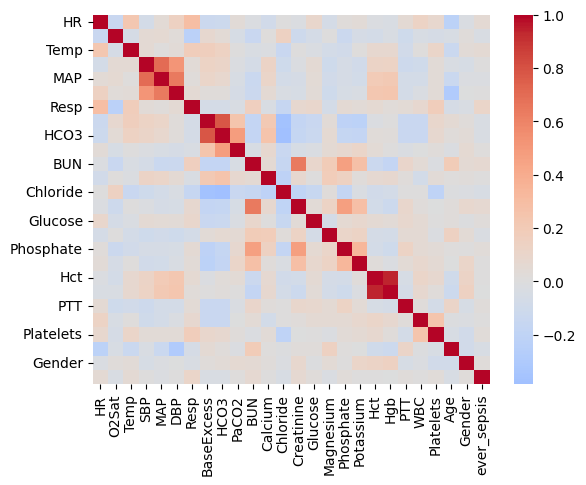

In [14]:
#correlation plot
# calculate the correlation matrix
corr = df_final.corr()

# plot the correlation matrix using a heatmap
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title("Correlation Matrix before drop correlated variables")
plt.show()

In [15]:
# drop SBP and Hct column
df_final = df_final.drop(columns=['SBP','DBP', 'Hct', 'BaseExcess', 'BUN'])


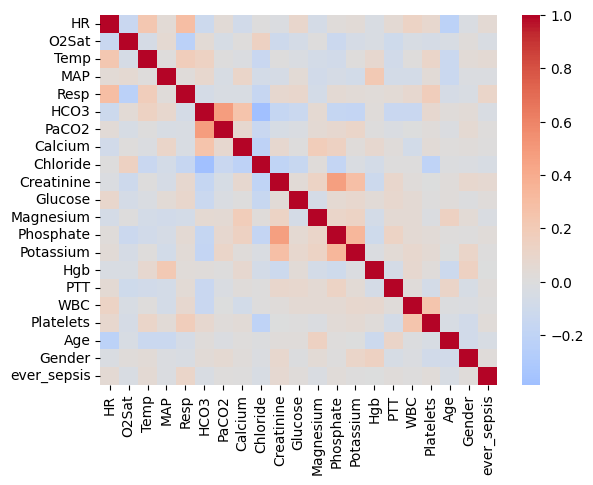

In [16]:
#correlation plot
# calculate the correlation matrix
corr = df_final.corr()

# plot the correlation matrix using a heatmap
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title("Correlation Matrix after drop correlated variables")
plt.show()

In [17]:
# split the data into training and test sets with a 70:30 ratio
X_train, X_test, y_train, y_test = train_test_split(df_final.drop('ever_sepsis', axis=1), 
                                                    df_final['ever_sepsis'], 
                                                    test_size=0.4, 
                                                    random_state=911)

In [18]:
# check the counts in 'y_train'
print("y_train:")
print(y_train.value_counts())

# check the counts in 'y_test'
print("y_test:")
print(y_test.value_counts())


y_train:
0    3514
1     605
Name: ever_sepsis, dtype: int64
y_test:
0    2368
1     378
Name: ever_sepsis, dtype: int64


### Feature selection using random forest

Recursive Feature Elimination with Cross-Validation (RFECV) to perform feature selection with a Random Forest classifier. RFECV is a method that recursively removes the least important features and evaluates the performance of the model using cross-validation. This process continues until the optimal number of features is determined.

In [19]:
# package
from sklearn.feature_selection import RFECV

In [20]:
# random forest model
rf = RandomForestClassifier(n_estimators=100, random_state=911)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=911)

In [21]:
# feature importance
importances = rf.feature_importances_

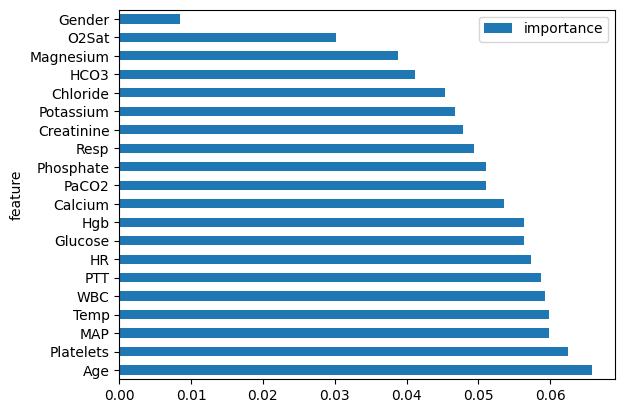

In [22]:
# create a dataset with feature importance
feature_importances = pd.DataFrame({'feature': X_train.columns, 'importance': importances})
feature_importances = feature_importances.sort_values('importance', ascending=False).reset_index(drop=True)

# bar plot
feature_importances.plot.barh(x='feature', y='importance')
plt.show()

In [23]:
# RFECV feature selection to optimal set
rfe = RFECV(rf,cv=5,scoring="neg_mean_squared_error")

rfe.fit(X_train,y_train)

RFECV(cv=5, estimator=RandomForestClassifier(random_state=911),
      scoring='neg_mean_squared_error')

In [24]:
# get selected features
selected_features_mask = rfe.get_support()
selected_feature_names = X_train.columns[selected_features_mask]

print("Selected features:")
for feature_name in selected_feature_names:
    print(feature_name)
    
number_of_selected_features_rf = len(selected_feature_names)
print("Number of selected features:", number_of_selected_features_rf)


Selected features:
HR
O2Sat
Temp
MAP
Resp
HCO3
PaCO2
Calcium
Chloride
Creatinine
Glucose
Magnesium
Phosphate
Potassium
Hgb
PTT
WBC
Platelets
Age
Number of selected features: 19


In [25]:
# new dataset
X_train_selected_rf = rfe.transform(X_train)
X_test_selected_rf = rfe.transform(X_test)

In [26]:
# new model
rf_selected = RandomForestClassifier(n_estimators=100, random_state=911)
rf_selected.fit(X_train_selected_rf, y_train)
y_pred = rf_selected.predict(X_test_selected_rf)

### Feature selection using LASSO
Here a feature selection using LASSO is performed. In this code, we implemented a LASSO (Least Absolute Shrinkage and Selection Operator) regression with 5-fold cross-validation using scikit-learn. The scoring method used to evaluate the model is the negative mean squared error (MSE). The reason for using the negative MSE is that GridSearchCV maximizes the score, and since we want to minimize the MSE, we use the negative value.

After LASSO, we selected coefficients that not equal to zero, which considered as significant variables. Then transform the X train and test, fit the reduced dataset into a logistic regression as our final model.

In [27]:
# packages
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegressionCV

In [28]:
# LASSO model with 5 fold CV
param_grid = {'alpha': np.arange(0.1,10,0.1)}
lasso = Lasso()
grid_search = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_lasso = grid_search.best_estimator_


In [29]:
# coefficients and selected features
selected_features_mask = best_lasso.coef_ != 0
selected_feature_names = X_train.columns[selected_features_mask]


In [30]:
print("Selected features:")
for feature_name in selected_feature_names:
    print(feature_name)
    
number_of_selected_features_lasso = len(selected_feature_names)
print("Number of selected features:", number_of_selected_features_lasso)


Selected features:
HR
MAP
Resp
Glucose
PTT
Platelets
Age
Number of selected features: 7


In [31]:
# selected dataset
X_train_selected_lasso = X_train.loc[:, selected_features_mask]
X_test_selected_lasso = X_test.loc[:, selected_features_mask]


In [32]:
# fit logistic model
logreg = LogisticRegressionCV(cv=5, penalty='l1', solver='liblinear', random_state=911)
logreg.fit(X_train_selected_lasso, y_train)
y_pred_prob_lasso = logreg.predict_proba(X_test_selected_lasso)[:, 1]


### Stepwise selection using p-value
A backward selection using p value is performed here. In this code, the function stepwise_pvalue_backward starts with the full set of variables, fits a logistic regression model, and eliminates the variable with the largest p-value above the threshold until all remaining variables have p-values less than 0.05.

This function returns final model summary, the final selected variables, the number of the final variable set

In [33]:
# packages
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [34]:
# function 
def stepwise_pvalue_backward(X, y, threshold=0.05):
    data = pd.concat([X, y.to_frame()], axis=1)
    response = y.name
    # creates a set of predictor variable names
    remaining_variables = set(data.columns) - {response}
    # convert to list
    selected_variables_pval = list(remaining_variables)

    while True:
        model_formula = response + " ~ " + " + ".join(selected_variables_pval)
        model = smf.glm(formula=model_formula, data=data, family=sm.families.Binomial()).fit()
        p_values = model.pvalues.drop('Intercept')

        max_p_value = max(p_values)
        # get index of largest p value variable in each iteration
        max_p_var = p_values.idxmax()

        if max_p_value > threshold:
            selected_variables_pval.remove(max_p_var)
        else:
            break

    final_formula = response + " ~ " + " + ".join(selected_variables_pval)
    final_model_pval = smf.glm(formula=final_formula, data=data, family=sm.families.Binomial()).fit()

    return final_model_pval, final_model_pval.summary(), selected_variables_pval, len(selected_variables_pval)


In [35]:
# implement 
final_model_pval, model_summary_pval, selected_vars_pval, num_selected_vars_pval = stepwise_pvalue_backward(X_train, y_train)

In [36]:
# Predict the probabilities for the test set
X_test_selected_pval = X_test[selected_vars_pval]
test_data_pval = pd.concat([X_test_selected_pval, y_test.to_frame()], axis=1)
y_test_pred_proba_pval = final_model_pval.predict(test_data_pval)

### Stepwise selection using AIC 

This code perform a stepwise selection using AIC. Inside the while loop, we calculate the AIC of the current model using model.aic. If the AIC of the current model is lower than the best AIC found so far, update the best AIC, best model, and best selected variables accordingly.

The loop continues until there are no remaining variables in the model. The function then returns the best model (with the lowest AIC), the best model summary, the list of best-selected variables, and the number of best-selected variables.

In [37]:
def stepwise_aic_backward(X, y):
    data = pd.concat([X, y.to_frame()], axis=1)
    response = y.name
    remaining_variables = set(data.columns) - {response}
    selected_variables = list(remaining_variables)

    best_aic = float('inf')
    best_model = None
    best_selected_vars = []

    while len(selected_variables) > 0:
        model_formula = response + " ~ " + " + ".join(selected_variables)
        model = smf.glm(formula=model_formula, data=data, family=sm.families.Binomial()).fit()
        model_aic = model.aic

        if model_aic < best_aic:
            best_aic = model_aic
            best_model = model
            best_selected_vars = selected_variables.copy()

        # Remove variable with the highest p-value
        p_values = model.pvalues.drop('Intercept')
        max_p_var = p_values.idxmax()
        selected_variables.remove(max_p_var)

    return best_model, best_model.summary(), best_selected_vars, len(best_selected_vars)


In [38]:
# implement 
final_model_AIC, model_summary_AIC, selected_vars_AIC, num_selected_vars_AIC = stepwise_aic_backward(X_train, y_train)

In [39]:
selected_vars_AIC

['Magnesium',
 'WBC',
 'Platelets',
 'Potassium',
 'PaCO2',
 'Gender',
 'Creatinine',
 'HCO3',
 'Resp',
 'Temp']

In [40]:
num_selected_vars_AIC

10

In [41]:
# Predict the probabilities for the test set
X_test_selected_AIC = X_test[selected_vars_AIC]
test_data_AIC = pd.concat([X_test_selected_AIC, y_test.to_frame()], axis=1)
y_test_pred_proba_AIC = final_model_AIC.predict(test_data_AIC)

### Reference models 
We next created two reference models for compare reduced models vs full models. In other words, to access the necessary of variable selection. Full variable set logistic regression and random forest at defualt settings are used.

### Logistic regression full model 

Here we construct a full variable set logistic regression without variable selection, used as reference model to compare the model performance improvement between full model and reduced model. Logistic regression is reference model for regression based models (p-value, AIC and LASSO).

In [42]:
# packages
from sklearn.linear_model import LogisticRegression

In [43]:
# logistic regression model
logistic_full_model = LogisticRegression(solver='liblinear', random_state=911).fit(X_train, y_train)

In [44]:
# Predict 
y_test_pred_proba_logistic = logistic_full_model.predict_proba(X_test)[:, 1]

### Random forest full model 

We run a random forest model without selection. Use as reference model for performance comparison between reduced random forest. 

In [45]:
# packages
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [46]:
# set up the random forest classifier
rf_full = RandomForestClassifier(random_state = 123)

# define a grid of hyperparameters to search over using cross-validation
param_grid = {'n_estimators': [50, 100, 200],
              'max_depth': [5, 10, 20]}

# use grid search to find the best hyperparameters
rf_full_model = GridSearchCV(rf_full, 
                           param_grid = param_grid,
                           scoring = 'accuracy',
                           cv = StratifiedKFold(5, shuffle = True, random_state = 123), 
                           n_jobs=-1, )

rf_full_model.fit(X_train, y_train)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=True),
             estimator=RandomForestClassifier(random_state=123), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 20],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [47]:
# Predict 
y_test_pred_proba_full_rf = rf_full_model.predict_proba(X_test)[:, 1]

### Evaluation using ROC and AUC

We ploted ROC curve and the corresponding AUC of each model, including the full models. All models except LASSO have similar AUC (~ 0.62, Lasso 0.48). For random forest, full model had slightly higher AUC than reduced model, 0.63 vs 0.62. For the rest regression based models, stepwise selection using p value has the highest AUC: 0.62. Stepwise selection using AIC has the same AUC as the reference logistic model: 0.61. LASSO has the lowest AUC: 0.48. 

In [48]:
# package
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [49]:
# random forest model
y_pred_prob_rf = rf_selected.predict_proba(X_test_selected_rf)[:, 1]

# ROC and AUC
fpr_rf, tpr_rf, thresholds = roc_curve(y_test, y_pred_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# LASSO
y_pred_prob_lasso = logreg.predict_proba(X_test_selected_lasso)[:, 1]

# ROC and AUC
fpr_lasso, tpr_lasso, thresholds = roc_curve(y_test, y_pred_prob_lasso)
roc_auc_lasso = auc(fpr_lasso, tpr_lasso)

# Stepwise selection using p value
# ROC and AUC
fpr_pval, tpr_pval, thresholds = roc_curve(y_test, y_test_pred_proba_pval)
roc_auc_pval = auc(fpr_pval, tpr_pval)

# Stepwise selection using AIC
# ROC and AUC
fpr_aic, tpr_aic, thresholds = roc_curve(y_test, y_test_pred_proba_AIC)
roc_auc_aic = auc(fpr_aic, tpr_aic)

## reference models
# random forest ROC and AUC
fpr_full_rf, tpr_full_rf, thresholds_rf = roc_curve(y_test, y_test_pred_proba_full_rf)
roc_auc_full_rf = auc(fpr_full_rf, tpr_full_rf)

# logistic regression
fpr_logistic, tpr_logistic, thresholds_logistic = roc_curve(y_test, y_test_pred_proba_logistic)
roc_auc_logistic = auc(fpr_logistic, tpr_logistic)

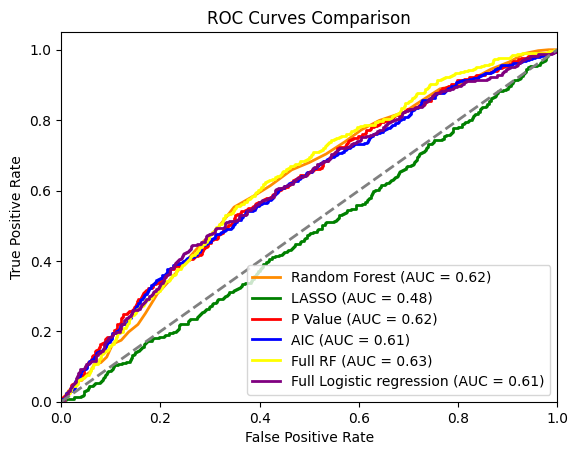

In [50]:
# plot the ROC curves
plt.figure()
lw = 2

# plot Random forest ROC 
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=lw, label='Random Forest (AUC = %0.2f)' % roc_auc_rf)

# plot LASSO ROC 
plt.plot(fpr_lasso, tpr_lasso, color='green', lw=lw, label='LASSO (AUC = %0.2f)' % roc_auc_lasso)

# plot stepwise selection using pvalue
plt.plot(fpr_pval, tpr_pval, color='red', lw=lw, label='P Value (AUC = %0.2f)' % roc_auc_pval)

# plot stepwise selection using AIC
plt.plot(fpr_aic, tpr_aic, color='blue', lw=lw, label='AIC (AUC = %0.2f)' % roc_auc_aic)

# plot reference random forest model
plt.plot(fpr_full_rf, tpr_full_rf, color='yellow', lw=lw, label='Full RF (AUC = %0.2f)' % roc_auc_full_rf)

# logistic model
plt.plot(fpr_logistic, tpr_logistic, color='purple', lw=lw, label='Full Logistic regression (AUC = %0.2f)' % roc_auc_logistic)


# plot reference line
plt.plot([0, 1], [0, 1], color='gray', lw=lw, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend(loc="lower right")
plt.show()

### Evalutation using parsimony plot
A parsimony plot is used to further assess the relationship of models between AUC and sparsity. When a model is both sparse and good in prediction accuracy, it is called parsimonious. Sparsity refers to the model using the least number of variables selected. 

The best model is stepwise selection using p value, it has the highest AUC (0.62) and the lowest number of variables selected (6 variables). Stepwise selection using AIC performs similar as using p value but with slightly higher variables selected (10 variables). Random forest have similar AUC as using p value, however, it has higher variable selected (19 variables). LASSO has relatively low number of variables selected (7 variables) but the AUC is the worest (0.48).

In [53]:
# Construct dataset 
model_comparison_data = {
    'Model Name': ['Random Forest', 'Lasso', 'AIC', 'P-Value'],
    'Sparsity': [
        number_of_selected_features_rf,
        number_of_selected_features_lasso,
        num_selected_vars_AIC,
        num_selected_vars_pval
    ],
    'AUC': [
        roc_auc_rf,
        roc_auc_lasso,
        roc_auc_aic,
        roc_auc_pval
    ],
    'AUC_change': [
        roc_auc_rf - roc_auc_full_rf,
        roc_auc_lasso - roc_auc_logistic,
        roc_auc_aic - roc_auc_logistic,
        roc_auc_pval - roc_auc_logistic
    ]
}

# as DataFrame
model_comparison_df = pd.DataFrame(model_comparison_data)

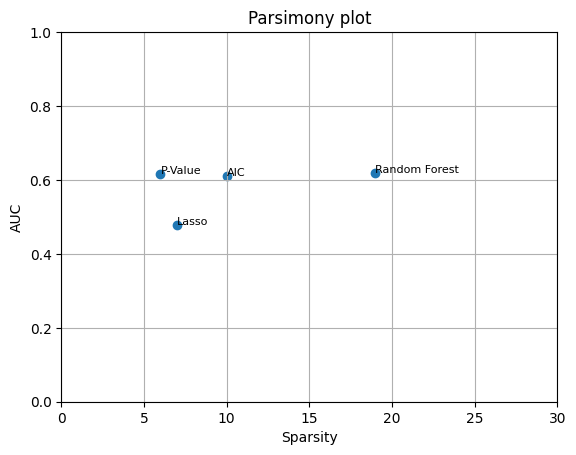

In [60]:
# parsimony plot 
plt.figure()
plt.scatter(model_comparison_df['Sparsity'], model_comparison_df['AUC'])

# annotate each point with the model name
for index, row in model_comparison_df.iterrows():
    plt.annotate(row['Model Name'], (row['Sparsity'], row['AUC']), fontsize=8)
    
plt.xlabel('Sparsity')
plt.ylabel('AUC')
plt.title('Parsimony plot')
plt.grid(True)
plt.ylim(0, 1)
plt.xlim(0,30)
plt.show()


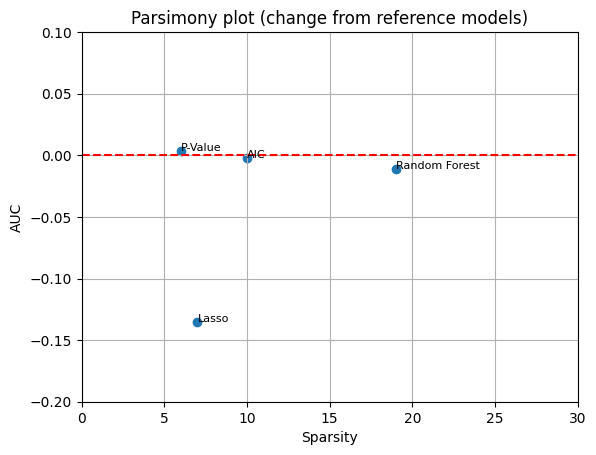

In [63]:
# parsimony plot (change from reference model)
plt.figure()
plt.scatter(model_comparison_df['Sparsity'], model_comparison_df['AUC_change'])

# annotate each point with the model name
for index, row in model_comparison_df.iterrows():
    plt.annotate(row['Model Name'], (row['Sparsity'], row['AUC_change']), fontsize=8)

# reference line at y = 0
plt.axhline(y=0, color='red', linestyle='--')

plt.xlabel('Sparsity')
plt.ylabel('AUC')
plt.title('Parsimony plot (change from reference models)')
plt.grid(True)
plt.ylim(-0.2, 0.1)
plt.xlim(0,30)
plt.show()


## Best model (Stepwise selection using P value) varaible set

We used the best method (stepwise selection using p value) model summary and came up with a brief model interpretation. 

The most important variables are: 'Magnesium' (log odds -0.2376), 'PaCO2'(log odds 0.0128), 'Creatinine' (log odds 0.0989), 'HCO3' (log odds -0.0273), 'Resp' (log odds 0.0399), 'Temp' (log odds 0.152). 

In [65]:
print('Best model variable set is:', selected_vars_pval)

Best model variable set is: ['Magnesium', 'PaCO2', 'Creatinine', 'HCO3', 'Resp', 'Temp']


In [64]:
model_summary_pval

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            ever_sepsis   No. Observations:                 4119
Model:                            GLM   Df Residuals:                     4112
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1682.9
Date:                Sat, 29 Apr 2023   Deviance:                       3365.7
Time:                        16:30:07   Pearson chi2:                 4.07e+03
No. Iterations:                     5   Pseudo R-squ. (CS):            0.01725
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -7.5913      1.680     -4.519      0.000     -10.883      -4.299
Magnesium     -0.2376      0.107     -2.223      0.026      -0.447      -0.028
PaCO2          0.0128      0.005      2.480      0.013       0.003       0.023
Creatinine     0.0989      0.029      3.405      0.001       0.042       0.156
HCO3          -0.0273      0.012     -2.324      0.020      -0.050      -0.004
Resp           0.0399      0.008      5.041      0.000       0.024       0.055
Temp           0.1520      0.046      3.300      0.001       0.062       0.242
==============================================================================
"""

## Discussion & Conclusions

#### Stepwise selection using p value is the best method
We tested four different variable selection methods: Stepwise selection using p value, stepwise selection using AIC, LASSO and random forest. We observed stepwise selection using p value is the best model in terms of the highest AUC (0.63) and lowest number of variables selected (5 variables). Stepwise selection using AIC performs similar as using p value but with slightly higher variables selected (10 variables). Random forest have similar AUC as using p value, however, it has higher variable selected (19 variables). LASSO has relatively low number of variables selected (7 variables) but the AUC is the worest (0.48). Regression based models requires less variables to achieve the similar model performance as decision tree based model. 

#### logistic regression based methods are stable in low events per variable (EPV) ratio
Logistic regression based methods perform more stable in low events per variable (EPV) situation. Previous study [1] demonstrated that LASSO nad Random forest perform well when the sample size and events per variable (EPV) ratio were large (EPV > 200), where EPV ratio stands for the events divided by the number of variables selected in the training dataset. Here, the EPV for LASSO is 305 events / 7 variables = 43.6, random forest is 305 events / 19 variables = 16.05. It is reasonable that these two models are not performing at optimal performance. In contrast, the same study demonstrated logistic regression perfored consistently across different sample size and lower EPV ratio (EPV 20~50). Our result is ocnsistent with the study. Stepwise selection using p value and AIC are logistic regression based and they perform stable here. 

#### Variable set interpretation
As demonstrated above, the most important variables are: 'Magnesium' (log odds -0.2376, odds ratio 0.79), 'PaCO2'(log odds 0.0128, odds ratio 1.01), 'Creatinine' (log odds 0.0989, odds ratio 1.1), 'HCO3' (log odds -0.0273, odds ratio 0.97), 'Resp' (log odds 0.0399, odds ratio 1.04), 'Temp' (log odds 0.152, odds ratio 1.16). 

Magnesium: If a patient baseline blood Magnesium increase by 1 mmol/dL while keep all the other variables constant, the odds of get sepsis is 0.79 times lower. 

PaCO2: For every 1 mm Hg baseline partial pressure of carbon dioxide from arterial blood increase while keep all the other variables constant, the odds of get sepsis is 1% higher. 

Creatinine: For every 1 mg/dL baseline blood creatinine increase while keep all the other variables constant, the odds of get sepsis is 10% higher. 

HCO3: For every 1 mmol/L baseline Bicarbonate increase while keep all the other variables constant, the odds of get sepsis is 3% lower. 

Resp: For every 1 time breath per minute baseline increase while keep all the other variables constant, the odds of get sepsis is 4% higher.

Temp: For every 1 degree celcius temperature baseline increase while keep all the other variables constant, the odds of get sepsis is 16% higher.

#### Limitation
This study has some limitations that should be acknowledged. Firstly, although we have large enough sample size, more events is preferred to verify the validity of result and more generalizable. Secondly, it is important to notice that we did not hit a good enough AUC. Although we did find a set of statistically significant variables, we have relatively undesireable AUC. The highest AUC is 0.63. This is consistent with the correlation plot earlier and this may suggest that the outcome sepsis might lack correlation with the predictors. 

#### Conclusion
In conclusion, regression based varaible selection methods perform more stable at relatively low EPV ratio. Stepwise selection using p value is the best method in our study. The best variable set is: 'Magnesium', 'PaCO2', 'Creatinine', 'HCO3', 'Resp', 'Temp'. However, it worth notice that the outcome did not strongly correlated with the predictors. 

## Reference 

1.  van der Ploeg, T., Austin, P.C. & Steyerberg, E.W. Modern modelling techniques are data hungry: a simulation study for predicting dichotomous endpoints. BMC Med Res Methodol 14, 137 (2014). https://doi.org/10.1186/1471-2288-14-137

## Supplementary 

#### Variable details
##### Outcome
Ever_sepsis: if a patient is ever diagnosis as sepsis, yes (1), no (0)
##### Predictors
HR:	Heart rate (beats per minute)

O2Sat:	Pulse oximetry (%)

Temp:	Temperature (Deg C)

SBP:	Systolic BP (mm Hg)

MAP:	Mean arterial pressure (mm Hg)

DBP:	Diastolic BP (mm Hg)

Resp:	Respiration rate (breaths per minute)

EtCO2:	End tidal carbon dioxide (mm Hg)

BaseExcess:	Measure of excess bicarbonate (mmol/L)

HCO3:	Bicarbonate (mmol/L)

FiO2:	Fraction of inspired oxygen (%)

pH:	N/A

PaCO2:	Partial pressure of carbon dioxide from arterial blood (mm Hg)

SaO2:	Oxygen saturation from arterial blood (%)

AST:	Aspartate transaminase (IU/L)

BUN:	Blood urea nitrogen (mg/dL)

Alkalinephos:	Alkaline phosphatase (IU/L)

Calcium:	(mg/dL)

Chloride:	(mmol/L)

Creatinine:	(mg/dL)

Bilirubin_direct:	Bilirubin direct (mg/dL)

Glucose:	Serum glucose (mg/dL)

Lactate:	Lactic acid (mg/dL)

Magnesium:	(mmol/dL)

Phosphate:	(mg/dL)

Potassium:	(mmol/L)

Bilirubin_total:	Total bilirubin (mg/dL)

TroponinI:	Troponin I (ng/mL)

Hct:	Hematocrit (%)

Hgb:	Hemoglobin (g/dL)

PTT:	partial thromboplastin time (seconds)

WBC:	Leukocyte count (count*10^3/µL)

Fibrinogen:	(mg/dL)

Platelets:	(count*10^3/µL)

Age:	Years (100 for patients 90 or above)

Gender:	Female (0) or Male (1)